# How to call image-to-text DIAL applications

From [this notebook](https://github.com/epam/ai-dial/blob/main/dial-cookbook/examples/how_to_call_image_to_text_applications.ipynb), you will learn how to call image-to-text DIAL applications via [DIAL API chat/completions](https://epam-rail.com/dial_api#/paths/~1openai~1deployments~1%7BDeployment%20Name%7D~1chat~1completions/post) call.

**DIAL application** is a general term, which encompasses model adapters and application with any custom logic.

DIAL currently supports a few image-to-text model adapters:

* [GPT4-Vision](https://github.com/epam/ai-dial-adapter-openai/)
* [Gemini Pro Vision](https://github.com/epam/ai-dial-adapter-vertexai/)

These models follow the same pattern of usage - they take the chat history of interactions between user and model, some of the user messages may contain image attachments, which the model takes into account when it generates the response.

The typical use case is to attach an image to a message and ask the model to describe it in the same message.

For example purposes, we are going to use a sample `image-size` image-to-text application which returns dimensions of an attached image.

## Setup

**Step 1**: install the necessary dependencies and import the libraries we are going to use.

In [1]:
%pip install -r ../python-notebooks-runner/requirements.txt > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import openai
import langchain_openai

**Step 2**: run `docker compose` in a separate terminal to start the **DIAL Core** server locally along with the `image-size` application.

```sh
(cd ..; docker compose up core image-size)
```

**Step 3**: configure DIAL Core URL: it will be `http://localhost:8080`, if the DIAL Core is run locally.

In [3]:
import os
dial_url = os.environ.get("DIAL_URL", "http://localhost:8080")
os.environ["DIAL_URL"] = dial_url

**Step 4**: define helpers to read images from disk and display images in the notebook:

In [4]:
import base64

from IPython.display import Image as IPImage
from IPython.display import display

def display_base64_image(image_base64):
    image_binary = base64.b64decode(image_base64)
    display(IPImage(data=image_binary))

def read_image_base64(image_path: str) -> str:
    with open(image_path, "rb") as image_file:
        image_base64 = base64.b64encode(image_file.read()).decode()
    return image_base64


## Using Curl

* The application deployment is called `image-size`.
* The local DIAL Core server URL is `dial_url`.
* The OpenAI API version we are going to use is `2023-03-15-preview`.

Therefore, the application is accessible via the URL:

```
http://${DIAL_URL}/openai/deployments/image-size/chat/completions?api-version=2023-03-15-preview
```

The corresponding curl command with a singe message in the request is:

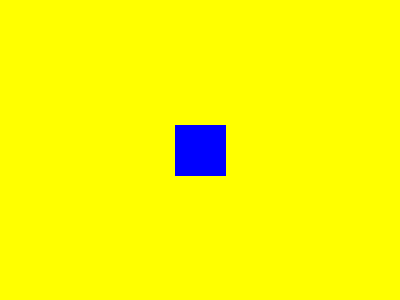

{"choices":[{"index":0,"finish_reason":"stop","message":{"role":"assistant","content":"Size: 400x300px"}}],"usage":null,"id":"efd7d61f-fb75-4116-a3b2-1d9d72a69fbf","created":1706540426,"object":"chat.completion"}

In [5]:
image_base64 = read_image_base64("./data/images/square.png")
os.environ["IMAGE_BASE64"] = image_base64

display_base64_image(image_base64)

!curl -X POST "${DIAL_URL}/openai/deployments/image-size/chat/completions?api-version=2023-03-15-preview" \
  -H "Api-Key:dial_api_key" \
  -H "Content-Type:application/json" \
  -d '{ "messages": [ { "role": "user", "content": "", "custom_content": { "attachments": [ { "type": "image/png", "data": "'"${IMAGE_BASE64}"'" } ] } } ] }'

## Using Python Library Requests


Let's make an HTTP request from Python using `requests` library.

The arguments are identical to the curl command above.

Let's call the application in the **non-streaming** mode:


In [6]:
response = requests.post(
    f"{dial_url}/openai/deployments/image-size/chat/completions?api-version=2023-03-15-preview",
    headers={"Api-Key": "dial_api_key"},
    json={"messages": [{"role": "user", "content": "", "custom_content": {"attachments": [{"type": "image/png", "data": image_base64}]}}]},
)
body = response.json()
display(body)

message = body["choices"][0]["message"]
completion = message["content"]
print(f"Completion: {completion!r}")
assert completion == "Size: 400x300px", "Unexpected completion"

{'choices': [{'index': 0,
   'finish_reason': 'stop',
   'message': {'role': 'assistant', 'content': 'Size: 400x300px'}}],
 'usage': None,
 'id': '38d4ba22-ca41-495e-b856-54e59cdd347b',
 'created': 1706540426,
 'object': 'chat.completion'}

Completion: 'Size: 400x300px'


When **streaming is enabled**, the chat completion returns a sequence of messages, each containing a chunk of a generated response:

In [7]:
response = requests.post(
    f"{dial_url}/openai/deployments/image-size/chat/completions?api-version=2023-03-15-preview",
    headers={"Api-Key": "dial_api_key"},
    json={"messages": [{"role": "user", "content": "", "custom_content": {"attachments": [{"type": "image/png", "data": image_base64}]}}], "stream": True},
)
for chunk in response.iter_lines():
    print(chunk)

b'data: {"choices":[{"index":0,"finish_reason":null,"delta":{"role":"assistant"}}],"usage":null,"id":"4a11461e-7461-4698-a7d2-a159d43a25df","created":1706540426,"object":"chat.completion.chunk"}'
b''
b'data: {"choices":[{"index":0,"finish_reason":null,"delta":{"content":"Size: 400x300px"}}],"usage":null,"id":"4a11461e-7461-4698-a7d2-a159d43a25df","created":1706540426,"object":"chat.completion.chunk"}'
b''
b'data: {"choices":[{"index":0,"finish_reason":"stop","delta":{}}],"usage":null,"id":"4a11461e-7461-4698-a7d2-a159d43a25df","created":1706540426,"object":"chat.completion.chunk"}'
b''
b'data: [DONE]'
b''


## Using OpenAI Python SDK

The DIAL deployment could be called using [OpenAI Python SDK](https://pypi.org/project/openai/) as well.


In [8]:
openai_client = openai.AzureOpenAI(
    azure_endpoint=dial_url,
    azure_deployment="image-size",
    api_key="dial_api_key",
    api_version="2023-03-15-preview",
)

Let's call the application in the **non-streaming** mode:

In [9]:

chat_completion = openai_client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "",
            "custom_content": {"attachments": [{"type": "image/png", "data": image_base64}]}
        }
    ],
    model="image-size",
)
print(chat_completion)
message = chat_completion.choices[0].message
completion = message.content
print(f"Completion: {completion!r}")
assert completion == "Size: 400x300px", "Unexpected completion"

ChatCompletion(id='ee653700-5b2b-4d05-a9c2-9e7738fe61e2', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Size: 400x300px', role='assistant', function_call=None, tool_calls=None))], created=1706540426, model=None, object='chat.completion', system_fingerprint=None, usage=None)
Completion: 'Size: 400x300px'


Let's call the application in the **streaming** mode:

In [10]:
chat_completion = openai_client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "",
            "custom_content": {"attachments": [{"type": "image/png", "data": image_base64}]}
        }
    ],
    stream=True,
    model="image-size",
)
completion = ""
for chunk in chat_completion:
    print(chunk)
    content = chunk.choices[0].delta.content
    if content:
        completion += content
print(f"Completion: {completion!r}")
assert completion == "Size: 400x300px", "Unexpected completion"

ChatCompletionChunk(id='d87f105d-497a-40a6-9d3b-5e262f4ec3a9', choices=[Choice(delta=ChoiceDelta(content=None, function_call=None, role='assistant', tool_calls=None), finish_reason=None, index=0, logprobs=None)], created=1706540426, model=None, object='chat.completion.chunk', system_fingerprint=None, usage=None)
ChatCompletionChunk(id='d87f105d-497a-40a6-9d3b-5e262f4ec3a9', choices=[Choice(delta=ChoiceDelta(content='Size: 400x300px', function_call=None, role=None, tool_calls=None), finish_reason=None, index=0, logprobs=None)], created=1706540426, model=None, object='chat.completion.chunk', system_fingerprint=None, usage=None)
ChatCompletionChunk(id='d87f105d-497a-40a6-9d3b-5e262f4ec3a9', choices=[Choice(delta=ChoiceDelta(content=None, function_call=None, role=None, tool_calls=None), finish_reason='stop', index=0, logprobs=None)], created=1706540426, model=None, object='chat.completion.chunk', system_fingerprint=None, usage=None)
Completion: 'Size: 400x300px'


## Using LangChain

The [LangChain](https://pypi.org/project/langchain-openai/) library **is not suitable** as a client of image-to-text applications, since `langchain-openai<=0.0.2` ignores the additional fields in the request.

In [11]:
from langchain_core.messages import HumanMessage

llm = langchain_openai.AzureChatOpenAI(
    azure_endpoint=dial_url,
    azure_deployment="image-size",
    api_key="dial_api_key",
    api_version="2023-03-15-preview",
)

Let's call the application in the **non-streaming** mode:

In [12]:
extra_fields = {"custom_content": {"attachments": [{"type": "image/png", "data": image_base64}]}}

try:
  llm.generate(messages=[[HumanMessage(content="", additional_kwargs=extra_fields)]])

  raise Exception("Generation didn't fail")
except Exception as e:
  assert str(e) == "Error code: 422 - {'error': {'message': 'No image attachment was found in the last message', 'type': 'runtime_error', 'param': None, 'code': None}}", "Unexpected error"

Let's call the application in the **streaming** mode:

In [13]:

try:
    output = llm.stream(input=[HumanMessage(content="", additional_kwargs=extra_fields)])
    for chunk in output:
        print(chunk.dict())

    raise Exception("Generation didn't fail")
except Exception as e:
    assert str(e) == "Error code: 422 - {'error': {'message': 'No image attachment was found in the last message', 'type': 'runtime_error', 'param': None, 'code': None}}", "Unexpected error"
